In [2]:
import os
import sys
import glob
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
%matplotlib inline
%precision 4
plt.style.use('ggplot')
import pystan
import scipy.stats as stats
pd.set_option('max_rows', 1000)
pd.set_option('max_columns', 50)
from sqlalchemy import create_engine
import psycopg2 as pq
golf_db = 'postgresql://localhost:5432/golf'

In [3]:
def exec_sql(sqlTxt, result=False):  
    with pq.connect(golf_db) as conn:
        with conn.cursor() as cursor:
            cursor.execute(sqlTxt) 
            if result:
                return [row for row in cursor] 
        
def pd_from_sql(sqlTxt):
    with pq.connect(golf_db) as conn:
        return pd.read_sql_query(sqlTxt, conn)
    
def np_to_sql(arr, table):
    df = pd.DataFrame(arr)
    with pq.connect(golf_db) as conn:
        df.to_sql(table, conn, if_exists='append')
    

In [64]:
def convert(c):
    return c.lower().replace(' ', '_').replace('/', '_').replace('.', '_').replace('#', 'id').replace('(', '_').replace(')', '').replace('id_of', 'num_of')

In [83]:
engine = create_engine(golf_db)

In [63]:
files = ['data/rshot-2014.txt', 'data/rshot-2015.txt', 'data/rshot-2016.txt']

In [67]:
for f in files:
    print 'reading ' + f
    df = pd.read_csv(filepath_or_buffer=f, sep=';', skipinitialspace=True)
    print 'converting date file'
    df.columns = [convert(col) for col in df.columns]
    df['date'] = pd.to_datetime(df['date'])
    print 'writing to sql'
    df.to_sql(name= 'strokes', con= engine, if_exists= 'append')

reading data/rshot-2014.txt
converting date file
writing to sql
reading data/rshot-2015.txt
converting date file
writing to sql
reading data/rshot-2016.txt
converting date file
writing to sql


In [88]:
sqlTxt = '''
CREATE TABLE players (
     player_id    integer PRIMARY KEY,
     first_name   varchar(40) NOT NULL CHECK (first_name <> ''),
     last_name   varchar(40) NOT NULL CHECK (last_name <> '')
);
'''
exec_sql(sqlTxt)

-1


In [97]:
sqlTxt = '''
insert into players (player_id, first_name, last_name) 
select distinct player_id, player_first_name, player_last_name from strokes
'''
exec_sql(sqlTxt)

In [105]:
sqlTxt = '''
CREATE TABLE courses (
     year        integer,
     course_id    integer,
     name   varchar(40) NOT NULL CHECK (name <> ''),
     primary key (year, course_id) 
);
'''
exec_sql(sqlTxt)

In [106]:
sqlTxt = '''
insert into courses
select distinct year, course_id, course_name from strokes
'''
exec_sql(sqlTxt)

In [115]:
sqlTxt = '''
CREATE TABLE tournaments (
     year        integer,
     permanent_tournament_id    integer,
     name   varchar(100) NOT NULL CHECK (name <> ''),
     primary key (year, permanent_tournament_id) 
);
'''
exec_sql(sqlTxt)

In [116]:
sqlTxt = '''
insert into tournaments
select distinct year, permanent_tournament_id, tournament_name from strokes
'''
exec_sql(sqlTxt)

In [192]:
sqlTxt = '''
DROP TABLE IF EXISTS scores CASCADE;
CREATE TABLE scores (
     year        integer,
     date        timestamp,
     player_id   integer,
     permanent_tournament_id    integer,
     round       integer,
     score       integer,
     primary key (year, date, player_id, permanent_tournament_id, round) 
);

CREATE VIEW scores_view AS
  select * from scores
  order by year, player_id, permanent_tournament_id, date, round;
'''
exec_sql(sqlTxt)

In [193]:
sqlTxt = '''
insert into scores
select    year, date, player_id, permanent_tournament_id, round,  count(shot) as score
  from    strokes 
    group by year, date, player_id, permanent_tournament_id, round
    order by year, player_id, permanent_tournament_id, date, round
'''
exec_sql(sqlTxt)

In [190]:
sqlTxt = '''
CREATE OR REPLACE FUNCTION combine_scores()
   RETURNS integer AS $$
DECLARE 
 num_recs integer = 0;
 first boolean = TRUE;
 score_rec   RECORD;
 prev_score_rec RECORD;
 scores_cur CURSOR 
 FOR SELECT *
 FROM scores_view;
BEGIN
   -- Open the cursor
   OPEN scores_cur;
 
   LOOP
    -- fetch row into the film
      FETCH scores_cur INTO score_rec;
    -- exit when no more row to fetch
      EXIT WHEN NOT FOUND;
 
    -- process
      IF NOT first THEN 
        IF    score_rec.round = prev_score_rec.round 
          AND score_rec.player_id = prev_score_rec.player_id
          AND score_rec.permanent_tournament_id = prev_score_rec.permanent_tournament_id
          AND score_rec.year = prev_score_rec.year
          THEN 
            UPDATE scores SET score = score + prev_score_rec.score 
              WHERE year = score_rec.year
              AND   player_id = score_rec.player_id
              AND   date = score_rec.date
              AND   permanent_tournament_id = score_rec.permanent_tournament_id
              AND   round = score_rec.round;
            DELETE from scores 
              WHERE year = prev_score_rec.year
              AND   player_id = prev_score_rec.player_id
              AND   date = prev_score_rec.date
              AND   permanent_tournament_id = prev_score_rec.permanent_tournament_id
              AND   round = prev_score_rec.round;
            num_recs := num_recs + 1;
          score_rec.score = score_rec.score + prev_score_rec.score;
        END IF;
      ELSE
        first = FALSE;
      END IF;
      prev_score_rec = score_rec;
   END LOOP;
  
   -- Close the cursor
   CLOSE scores_cur;
 
   RETURN num_recs;
END; $$
 
LANGUAGE plpgsql;
'''
exec_sql(sqlTxt)
exec_sql('execute combine_rounds()')

In [27]:
sqlTxt = '''
DROP VIEW IF EXISTS stats_view;

CREATE VIEW stats_view AS 
  select s.year, s.player_id, first_name, last_name, avg(score) as avg_score, stddev(score) as std_score
      from scores as s, players p 
      where s.player_id = p.player_id 
      group by s.year, first_name, last_name, s.player_id
      having count(score) > 50
      order by year, avg_score;
'''
exec_sql(sqlTxt)


In [31]:
sqlTxt = '''
DROP VIEW IF EXISTS rank_view;

CREATE VIEW rank_view AS
    select year, player_id, ROW_NUMBER() over (order by avg_score) from stats_view;
'''
exec_sql(sqlTxt)

In [ ]:
#  DELETE ROUNDS WITHOUT 18 holes
sqlTxt = '''
delete from scores s
    where exists (select year, player_id, permanent_tournament_id, round, count(hole) 
      from (select    distinct year, player_id, permanent_tournament_id, round,  hole
          from    strokes) b
      where b.year = s.year 
        and b.player_id = s.player_id
        and b.permanent_tournament_id = s.permanent_tournament_id
        and b.round = s.round
      group by year, player_id, permanent_tournament_id, round
      having count(hole) < 18
)
'''
exec_sql(sqlTxt)


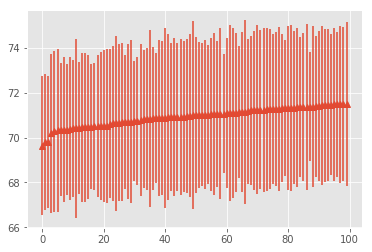

In [24]:
sqlTxt = '''
select * from stats_view where year = 2014 limit 100;
  
'''
df = pd_from_sql(sqlTxt)
foo = plt.errorbar(range(0, len (df)), df['avg_score'], df['std_score'], linestyle='None', marker='^')

216